# (0) Prepare env and install library


In [1]:
! pip install IPython pandas numpy scikit-learn requests langchain-core
! pip install -qU langchain-ollama 
! pip install langchain-chroma
! pip install -U langchain langchain-community
! pip install faiss-cpu tqdm
! ollama pull llama3.2-vision


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling 11f274007f09... 100% ▕████████████████▏ 6.0 GB                         
pulling ece5e659647a... 100% ▕████████████████▏ 1.9 GB                         
pulling 715415638c9c... 100% ▕████████████████▏  269 B                         
pulling 0b4284c1f870... 100% ▕████████████████▏ 7.7 KB                         
pulling fefc914e46e6... 100% ▕████████████████▏   32 B                         
pulling fbd313562bb7... 100% ▕████████████████▏  572 B                         
verifying sha256 digest 
writing manifest 
success 


# (0.1) import


In [2]:
import os
import uuid
import base64
import re
import requests
import ollama
from uuid import uuid4
from IPython import display
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from langchain_ollama import OllamaEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain_community.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever
from tqdm import tqdm
from langchain.llms import Ollama

# 1. Read dataset


In [2]:
def readData(path):
    data_df = pd.read_csv(path, encoding="utf-8", on_bad_lines="skip")

    imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    data_df = pd.DataFrame(imputer.fit_transform(data_df), columns=data_df.columns)

    for col in data_df.columns:
        missing = data_df[col].isnull().sum()
        missing_percent = missing / len(data_df) * 100
        print(f"{col}: {missing} missing values, {missing_percent:.2f}%")

    return data_df


In [ ]:
EC_df = readData("../Dataset/EC.csv")
print("\n 1: EC \n", EC_df.head())

In [ ]:
images_df=EC_df["image_url"].iloc[:240].values
style_df=EC_df.iloc[:, 0:8].iloc[:240].values
id=EC_df["timestamp"].iloc[:240].values
print(type(images_df))
print(style_df)
print(id)

# 2. Summary Image And Text


# Test summarise

<!-- text_elements = []
text_summaries = []

def generate_text_summaries(texts, summarize_texts=False):
    summary_prompt = """Summarize the following {element_type} : "{element}" """
    prompt_template = PromptTemplate.from_template(summary_prompt)

    def summarize(element, element_type="text"):
        formatted_prompt = prompt_template.format(element=element, element_type=element_type)
        response = ollama.chat(
            model="llama3.2-vision",
            messages=[{"role": "user", "content": formatted_prompt}],
        )
        return response.message.content

    if texts and summarize_texts:
        for i in tqdm(range(min(2,len(texts))), desc="Summarizing Texts"):
            text_elements.append(texts[i])
            text_summaries.append(summarize(texts[i]))
    elif texts:
        text_summaries.extend(texts)

    return text_summaries

texts = style_df.values.tolist()
text_elements, text_summaries = generate_text_summaries(texts, summarize_texts=True)
print("End summarizing the table and text") -->


In [ ]:
text_elements = []
text_summaries = []

def generate_text_summaries(texts,text_ids, summarize_texts=False):
    summary_prompt = """Summarize the following {element_type} : "{element}" """
    summary_prompt_template = PromptTemplate.from_template(summary_prompt)

    llm = Ollama(model="llama3.2-vision")
    summary_chain = LLMChain(llm=llm, prompt=summary_prompt_template)

    if texts and summarize_texts:
        for i in tqdm(range(len(texts)), desc="Summarizing Texts"):
            text_elements.append(texts[i])
            summary = summary_chain.run({'element_type': 'text', 'element': texts[i]})
            text_summaries.append(f"{text_ids[i]}: "+summary)
    elif texts:
        text_summaries.extend(texts) 

    return text_summaries

texts = style_df.tolist()  
text_ids=id.tolist()
text_summaries = generate_text_summaries(texts, text_ids, summarize_texts=True)

for i in range(len(text_elements)):
    print("\nText Elements:", text_elements[i])
    print("\nText Summaries:", text_summaries[i])

print("End summarizing the table and text")


# Image summaries


In [ ]:

image_elements = []
image_summaries = []

def encode_image(image_path):
    try:
        response = requests.get(image_path)
        response.raise_for_status()  
        image_data = response.content
        encoded_image = base64.b64encode(image_data).decode("utf-8")
        return encoded_image
    except Exception as e:
        print(f"Error encoding image at {image_path}: {e}")
        return None

def image_summarize(encoded_image):
    try:
        response = ollama.chat(
            model="llama3.2-vision",
            messages=[
                {
                    "role": "user",
                    "content": "Describe the contents of this image.",
                    "images": [encoded_image],
                },
                {
                    "role": "system",
                    "content": "You are a bot that is good at analyzing images related to computer.",
                }
            ],
        )
        return response.message.content 
    except Exception as e:
        print(f"Error summarizing image: {e}")
        return "Failed to summarize image."

def generate_img_summaries(image_links):
    for i in tqdm(range(len(image_links)), desc="Summarizing Images"):
        encoded_image = encode_image(image_links[i])
        if encoded_image is None:
            continue 
        
        print("Image link:", image_links[i])
        image_elements.append(encoded_image)
        summary = image_summarize(encoded_image)
        image_summaries.append(summary)  
        print("Summary: ", summary)

    return image_elements, image_summaries

image_links = images_df.tolist()
id_element=id.tolist()
image_elements, image_summaries = generate_img_summaries(image_links)
print("Image summaries completed.")


# Convert text_element to a string


In [ ]:
text_as_str = "\n".join([", ".join(map(str, sublist)) for sublist in text_elements])

print("text ",text_summaries[1]+"\n")

In [9]:
documents = []
retrieve_contents = []

id_doc=id.tolist()

for doc_id,text_summary, image_summary, text_element, image_element in zip(id_doc,text_summaries, image_summaries, text_elements, image_elements):
    combined_content = f"**Text Summary:**\n{text_summary}\n\n**Image Summary:**\n{image_summary}"

    # Tạo đối tượng Document
    doc = Document(
        page_content=combined_content,
        metadata={
            'id': doc_id,
            'type': 'combined',
            'original_content': {
                'id': doc_id,
                'text_summary': text_summary,
                'image_summary': image_summary,
                'text_element': text_element,
                'image_element': image_element
            }
        }
    )
    retrieve_contents.append(doc)
    documents.append(doc)


vectorstore = FAISS.from_documents(documents=documents, embedding=OllamaEmbeddings(model="llama3.2-vision"))
vectorstore.save_local("faiss_index")


# (3) Read doc at faiss


In [3]:
embeddings = OllamaEmbeddings(model="llama3.2-vision")
db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

# (3.1) prompt


In [12]:
prompt_template = """
Before answering any question or giving advice, you must request and verify the metadata ID from the provided context. If there is too much data, prioritize suggesting the top 5 results.  

You are an expert in computer components and configurations, with detailed knowledge of compatibility and optimization. Your responsibilities include:  

1. **Requesting and verifying the metadata ID**:  
   - Before providing detailed information, confirm the metadata ID from the context.  
   - If no metadata ID is found, respond with: "Please provide the metadata ID for detailed support."  
   - If a valid metadata ID is found, include it at the beginning of your response in the following format: `ID: metadata['id']`.  

2. **Providing detailed product information**:  
   - Extract and summarize the detailed information of the product corresponding to the provided metadata ID from the context.  
   - Filter out irrelevant products and provide details only on the relevant product.  

3. **Evaluating and making recommendations**:  
   - Provide a professional evaluation of the product, highlighting strengths and potential drawbacks.  
   - Offer appropriate advice or suggestions based on the given context.  

4. **Checking component compatibility (if applicable)**:  
   - Verify compatibility between CPU, GPU, motherboard, RAM, power supply, cooling system, and case.  
   - Ensure the socket type, RAM standard (DDR4, DDR5), power supply capacity, and GPU size meet the requirements.  

5. **Using only the provided context**:  
   - Retrieve all necessary information solely from the given context.  
   - If the context lacks relevant information, respond with: "Sorry, I don't have enough information on that."  

**Context**:  
{context}  

**Question**:  
{question}  

**Answer**:
"""

qa_chain = LLMChain(llm=Ollama(model="llama3.2-vision"), prompt=PromptTemplate.from_template(prompt_template))


# (4) funtion to get the image


In [5]:
def find_elementImage(result,rl):
    relevant_image_elements = []
    ids = set()
    check = ""

    regex = r"ID[:\s](\d+)|ID:[:\s](\d+)"
    matches = re.findall(regex, result)

    if matches:
        for match in matches:
            ids.add(match[0] or match[1]) 
    else:
        return False
    
    print("IDs: ", ids)
    
    for single_id in ids:
        for d in rl:
            original_content = d.metadata.get('original_content', {})

            if 'id' in original_content:
                check = str(original_content['id']).strip()

            if check == single_id:
                if 'image_element' in original_content:
                    print("Have Image ID: ", single_id)
                    relevant_image_elements.append(original_content['image_element'])
                    display.display(display.Image(base64.b64decode(str(original_content['image_element']))))
    return ids

# (5) The first function is to chat with AI


In [10]:
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []

    for d in relevant_docs:
        if 'id' in d.metadata['original_content']:
            context += f"ID:{d.metadata['original_content']['id']}\n"
        if 'text_summary' in d.metadata['original_content']:
            context += f"{d.metadata['original_content']['text_summary']}\n"
        if 'image_summary' in d.metadata['original_content']:
            context += f"Image Summary: {d.metadata['original_content']['image_summary']}\n"
        context += f"{d.page_content}\n"
    print("run AI")
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_docs

# (5.1) The second function is to chat with AI


In [7]:
def interactive_chat(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    
    for d in relevant_docs:
        if 'id' in d.metadata['original_content']:
            context += f"ID:{d.metadata['original_content']['id']}\n"
        if 'text_summary' in d.metadata['original_content']:
            context += f"{d.metadata['original_content']['text_summary']}\n"
        if 'image_summary' in d.metadata['original_content']:
            context += f"Image Summary: {d.metadata['original_content']['image_summary']}\n"
        context += f"{d.page_content}\n"
    
    print("Bot: ", end="", flush=True)

    response = ollama.chat(
        model="llama3.2-vision",
        stream=True,
        messages=[
            {"role": "system", "content": "You must only use the provided context to answer. Do not include any information from outside sources. " + context},
            {"role": "system", "content": prompt_template.format(context=context, question=question)},
            {"role": "user", "content": question},
            {"role": "assistant", "content": "Please provide the metadata ID for detailed support. You must write the ID in the format: ID: metadata['id']."},
            {"role": "assistant", "content": prompt_template.format(context=context, question=question)+ " Please provide detailed information about all relevant products, including specifications, features, and any additional details. If there are multiple products, list them clearly with their details."},
            {"role": "assistant", "content": "Based on the provided context, here is the detailed information about the product:"}
        ],
    )

    
    result = ""
    for chunk in response:
        content = chunk.message.content
        print(content, end="", flush=True)
        result += content    
    find_elementImage(result, relevant_docs)
    print()


# (6) Run AI


run AI
Để giúp bạn tìm được một thùng PC và card màn hình phù hợp với nhu cầu của mình, tôi sẽ đề xuất một số lựa chọn sau đây:

1. Thùng PC:
ID: 1604570935
Sản phẩm: MSI GeForce GTX 1660 Ventus XS OC graphics card
Giá: $230.90
Đánh giá: 9.53/10

2. Card màn hình:
ID: 1604570967
Sản phẩm: MSI GeForce RTX 2060 Gaming X Trio
Giá: $399.91
Đánh giá: 9.83/10

Tuy nhiên, nếu bạn đang tìm kiếm một lựa chọn rẻ hơn, thì ID: 1604570935 có thể là một lựa chọn phù hợp với nhu cầu của bạn.

Lưu ý rằng các thông tin trên chỉ mang tính chất tham khảo và không phải là khuyến nghị mua hàng cụ thể. Bạn nên kiểm tra thông tin chi tiết về sản phẩm và giá cả trước khi thực hiện bất kỳ quyết định nào.

Hy vọng thông tin này hữu ích cho bạn!
IDs:  {'1604570967', '1604570935'}
Have Image ID:  1604570967


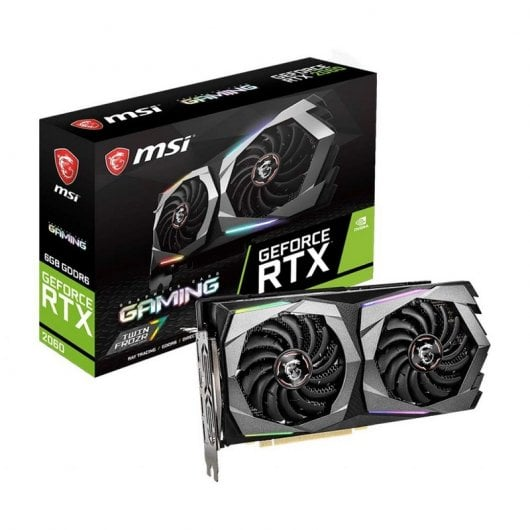

Have Image ID:  1604570935


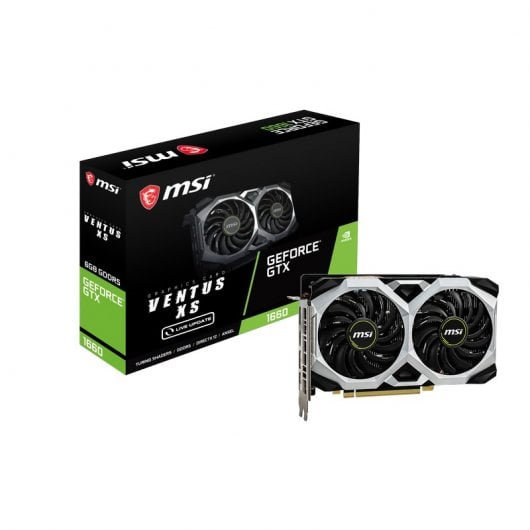

{'1604570935', '1604570967'}

In [13]:
question = "tôi cần 1 thùng pc và card màn hình rẻ cho PC "+"and give me ID of this component, you must write ID: metadata['id']"
result, relevant_docs = answer(question)
print(result)
find_elementImage(result,relevant_docs)

In [ ]:
question = "i need some graphic cards for pc, can you give me information of component"
interactive_chat(question)

In [ ]:
find_elementImage(result,relevant_docs)

In [ ]:
for rl in relevant_docs:
    print(rl.metadata['original_content']['id'])